In [10]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # Python Optimal Transport library
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

np.random.seed(42)

The following class implements the theoretical findings of Divol & Gaucher in the paper we are analysing.
*   It computes the Bayes Regressor $\eta(x)$.
*   It estimates the Discrimination Signal $\Delta(x)$ (propensity differences).
*   It solves a Sinkhorn Optimal Transport problem to find the barycenter between the "advantaged" and "disadvantaged" regions of the $(\eta, \Delta)$ space.
Although here Sinkhorn may not be needed (since we are in 1D).

In [11]:
class FastOTUnawareFairRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 base_regressor=None, 
                 base_classifier=None, 
                 correction_regressor=None,
                 reg_e=1e-2,          # Entropic regularization (Sinkhorn)
                 min_delta=1e-2,      # Stability threshold
                 max_samples_ot=1000): # Downsampling for speed
        self.base_regressor = base_regressor if base_regressor else LinearRegression()
        self.base_classifier = base_classifier if base_classifier else LogisticRegression(solver='liblinear')
        self.correction_regressor = correction_regressor if correction_regressor else HistGradientBoostingRegressor()
        
        self.reg_e = reg_e
        self.min_delta = min_delta
        self.max_samples_ot = max_samples_ot
        
        self.eta_model_ = None
        self.delta_model_ = None
        self.correction_model_ = None
        self.p_s1_ = None
        self.p_s2_ = None

    def fit(self, X, y, s):
        X = np.array(X)
        y = np.array(y)
        s = np.array(s)

        # 1. Fit Bayes Proxy (Eta) and Group Proxy (Delta)
        self.eta_model_ = clone(self.base_regressor).fit(X, y)
        eta_train = self.eta_model_.predict(X)

        self.p_s1_ = np.mean(s == 1)
        self.p_s2_ = np.mean(s == 0) # Assuming groups are 0 and 1
        
        self.delta_model_ = clone(self.base_classifier).fit(X, s)
        ps_pred = self.delta_model_.predict_proba(X)[:, 1]
        
        # Calculate Delta(x) (Paper Eq. 7)
        safe_p1 = np.clip(self.p_s1_, 1e-6, 1)
        safe_p2 = np.clip(self.p_s2_, 1e-6, 1)
        delta_vals = (ps_pred / safe_p1) - ((1 - ps_pred) / safe_p2)

        # 2. Filter Active Sets (Where proxy is strong enough)
        active_mask = np.abs(delta_vals) > self.min_delta
        
        eta_active = eta_train[active_mask]
        delta_active = delta_vals[active_mask]
        
        # Downsample for OT solver if needed
        if len(eta_active) > self.max_samples_ot:
            indices = np.random.choice(len(eta_active), self.max_samples_ot, replace=False)
            eta_active = eta_active[indices]
            delta_active = delta_active[indices]

        # Split into Plus (s=1 likely) and Minus (s=0 likely)
        idx_plus = np.where(delta_active > 0)
        idx_minus = np.where(delta_active < 0)
        
        h1 = eta_active[idx_plus]
        d1 = np.abs(delta_active[idx_plus])
        h2 = eta_active[idx_minus]
        d2 = np.abs(delta_active[idx_minus])

        # 3. Compute Cost Matrix (Paper Eq. 14)
        # C = (h1 - h2)^2 / (|d1| + |d2|)
        numer = (h1[:, None] - h2[None, :]) ** 2
        denom = (d1[:, None] + d2[None, :])
        M = numer / denom
        M /= M.max() # Normalize for Sinkhorn stability

        # 4. Solve Optimal Transport
        n1, n2 = len(h1), len(h2)
        a, b = np.ones(n1)/n1, np.ones(n2)/n2
        gamma = ot.sinkhorn(a, b, M, reg=self.reg_e)

        # 5. Compute Barycenter Targets (Paper Eq. 13 + Projection)
        inv_d1 = 1.0 / d1
        inv_d2 = 1.0 / d2
        num_matrix = (h1 * inv_d1)[:, None] + (h2 * inv_d2)[None, :]
        den_matrix = inv_d1[:, None] + inv_d2[None, :]
        Y_opt_pairs = num_matrix / den_matrix
        
        # Project mapped points
        y_fair_plus = np.sum(gamma * Y_opt_pairs, axis=1) * n1
        y_fair_minus = np.sum(gamma * Y_opt_pairs, axis=0) * n2
        
        # 6. Train Correction Model: f(eta, delta) -> shift
        X_train_features = np.vstack([
            np.column_stack([h1, delta_active[idx_plus]]),
            np.column_stack([h2, delta_active[idx_minus]])
        ])
        y_shifts = np.concatenate([y_fair_plus - h1, y_fair_minus - h2])
        
        self.correction_model_ = clone(self.correction_regressor).fit(X_train_features, y_shifts)
        return self

    def predict(self, X):
        X = np.array(X)
        eta_new = self.eta_model_.predict(X)
        
        ps = self.delta_model_.predict_proba(X)[:, 1]
        safe_p1 = np.clip(self.p_s1_, 1e-6, 1)
        safe_p2 = np.clip(self.p_s2_, 1e-6, 1)
        delta_new = (ps / safe_p1) - ((1 - ps) / safe_p2)
        
        features = np.column_stack([eta_new, delta_new])
        pred_shifts = self.correction_model_.predict(features)
        
        # Apply shift only if delta is significant
        mask_active = np.abs(delta_new) > self.min_delta
        final_pred = eta_new.copy()
        final_pred[mask_active] += pred_shifts[mask_active]
        
        return final_pred

## Data Generation
We simulate a dataset where the feature $X$ (e.g., "Experience/Skill") is correlated with the sensitive attribute $S$.
 *   **Group 0 (Disadvantaged)**: Lower average feature value.
 *   **Group 1 (Advantaged)**: Higher average feature value.
 *   **Target $Y$**: Depends on $X$, but also has a direct bias from $S$.
 
 $$X | S=0 \sim \mathcal{N}(0, 1)$$
 $$X | S=1 \sim \mathcal{N}(2, 1)$$
 $$Y = 0.8 X + 0.5 S + \mathcal{N}(0, 0.5)$$

Even if we remove $S$ (Unawareness) at prediction time, $X$ acts as a proxy for $S$. The Bayes regressor will pick up on this and predict higher values for Group 1 not just because of $X$, but because $X$ implies $S=1$ which implies a bonus.


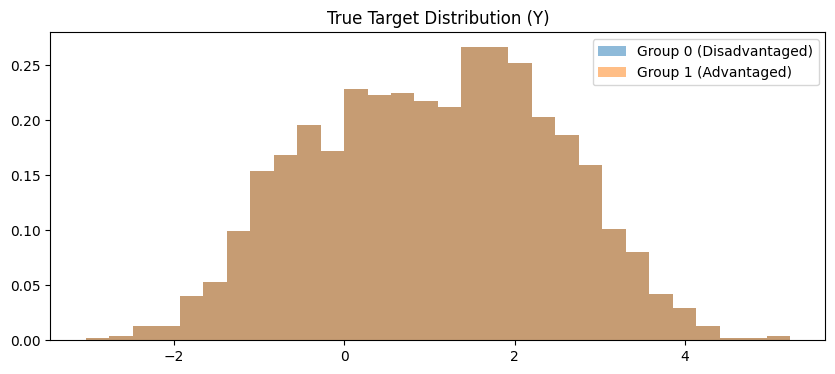

In [12]:
def generate_data(n=2000):
    s = np.random.binomial(1, 0.5, n)
    
    # Feature X depends on S (Correlation)
    x = np.random.normal(0, 1, n) + 2 * s 
    
    # Target Y depends on X and S (Direct Bias)
    # Note: Even though Y depends on X, the distributions of Y|S=0 and Y|S=1 are distinct.
    y = 0.8 * x + 0.5 * s + np.random.normal(0, 0.5, n)
    
    return x.reshape(-1, 1), y, s

X, y, S = generate_data()

# Split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, S, test_size=0.3, random_state=42)

# Visualize Data
plt.figure(figsize=(10, 4))
plt.hist(y, bins=30, alpha=0.5, label='Group 0 (Disadvantaged)', density=True)
plt.hist(y, bins=30, alpha=0.5, label='Group 1 (Advantaged)', density=True)
plt.title("True Target Distribution (Y)")
plt.legend()
plt.show()

## Training: Unaware Bayes vs. Fair Regressor

In [13]:
# 1. Standard Unaware Regressor (Linear Regression on X only)
bayes_model = LinearRegression()
bayes_model.fit(X_train, y_train)
y_pred_bayes = bayes_model.predict(X_test)

# 2. Fair Regressor
fair_model = FastOTUnawareFairRegressor()
fair_model.fit(X_train, y_train, s_train)
y_pred_fair = fair_model.predict(X_test)

# Calculate Errors
mse_bayes = mean_squared_error(y_test, y_pred_bayes)
mse_fair = mean_squared_error(y_test, y_pred_fair)

print(f"MSE (Bayes): {mse_bayes:.4f}")
print(f"MSE (Fair):  {mse_fair:.4f}")


MSE (Bayes): 0.2695
MSE (Fair):  1.6999


## Results: Visualization of Demographic Parity

 Here we verify if the Fair Regressor achieved its goal. 
 *   **Left**: The Bayes regressor produces separated distributions (Unfair).
 *   **Right**: The Fair regressor aligns the distributions (Demographic Parity).


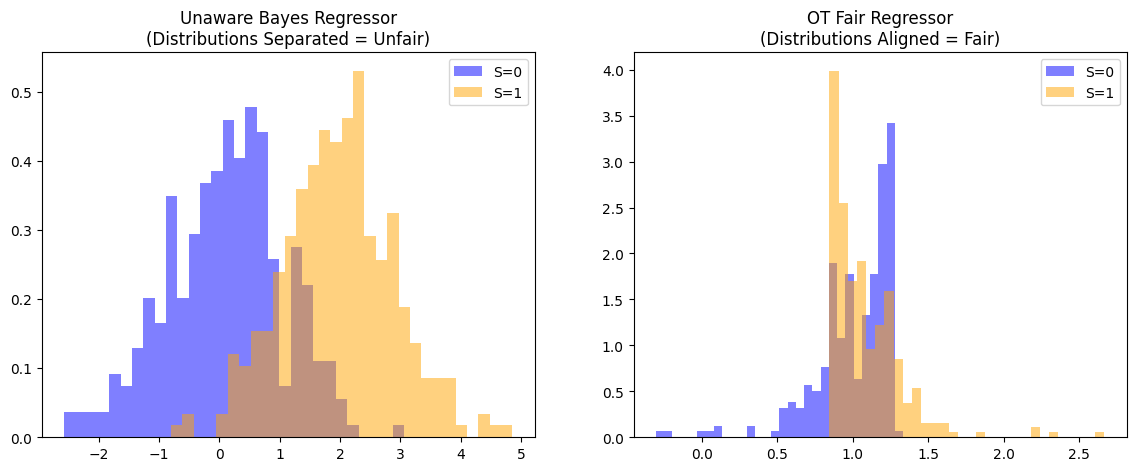

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Bayes
ax[0].hist(y_pred_bayes[s_test==0], bins=30, alpha=0.5, density=True, label='S=0', color='blue')
ax[0].hist(y_pred_bayes[s_test==1], bins=30, alpha=0.5, density=True, label='S=1', color='orange')
ax[0].set_title(f"Unaware Bayes Regressor\n(Distributions Separated = Unfair)")
ax[0].legend()

# Plot Fair
ax[1].hist(y_pred_fair[s_test==0], bins=30, alpha=0.5, density=True, label='S=0', color='blue')
ax[1].hist(y_pred_fair[s_test==1], bins=30, alpha=0.5, density=True, label='S=1', color='orange')
ax[1].set_title(f"OT Fair Regressor\n(Distributions Aligned = Fair)")
ax[1].legend()

plt.show()

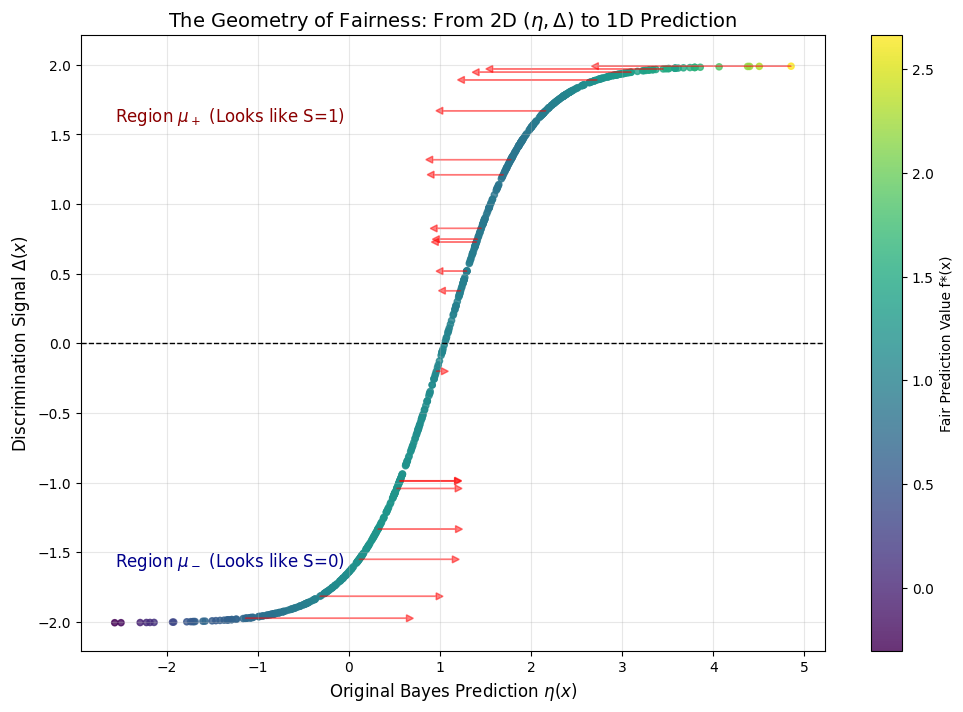

In [15]:
# Extract internal variables for visualization
eta_vis = fair_model.eta_model_.predict(X_test)
ps_vis = fair_model.delta_model_.predict_proba(X_test)[:, 1]
p1 = fair_model.p_s1_
p2 = fair_model.p_s2_
delta_vis = (ps_vis / p1) - ((1 - ps_vis) / p2)

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot: x=Eta, y=Delta, Color=Fair Prediction
sc = plt.scatter(eta_vis, delta_vis, c=y_pred_fair, cmap='viridis', alpha=0.8, s=20)
plt.colorbar(sc, label='Fair Prediction Value f*(x)')

# Add formatting
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Neutral Zone (Delta=0)')
plt.text(np.min(eta_vis), np.max(delta_vis)*0.8, "Region $\mu_+$ (Looks like S=1)", fontsize=12, color='darkred')
plt.text(np.min(eta_vis), np.min(delta_vis)*0.8, "Region $\mu_-$ (Looks like S=0)", fontsize=12, color='darkblue')

plt.title("The Geometry of Fairness: From 2D $(\eta, \Delta)$ to 1D Prediction", fontsize=14)
plt.xlabel("Original Bayes Prediction $\eta(x)$", fontsize=12)
plt.ylabel("Discrimination Signal $\Delta(x)$", fontsize=12)
plt.grid(True, alpha=0.3)

# Draw arrows to illustrate the "Transport" for a few sample points
indices = np.random.choice(len(eta_vis), 20, replace=False)
for i in indices:
    # Arrow from (eta, delta) to (fair_pred, delta)
    # This shows the horizontal shift applied by the model
    plt.arrow(eta_vis[i], delta_vis[i], 
              y_pred_fair[i] - eta_vis[i], 0, 
              color='red', alpha=0.5, head_width=0.05, length_includes_head=True)

plt.show()


### Explanation of the Barycenter Plot
 
This is what the standard model predicts. You can see that higher values are naturally correlated with $\Delta > 0$ (the advantaged group).
The red arrows represent the Optimal Transport Map.

     *   Points in the top half ($\Delta > 0$) are generally shifted left (prediction reduced) to correct for privilege.
     *   Points in the bottom half ($\Delta < 0$) are generally shifted right (prediction increased).
The color gradient becomes vertical. This means the final prediction $f^*(x)$ is independent of $\Delta(x)$, satisfying the condition that the prediction distribution is the same for both groups.